In [20]:
# import of standard python libraries
import numpy as np
import os
import time
import corner
import astropy.io.fits as pyfits
import sys
import argparse
from tqdm import tqdm
import pandas as pd
import gc
#sys.path.insert(0, '../lenstronomy/lenstronomy/')
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import kernel_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from deeplenstronomy.PopSim.population import *
from deeplenstronomy.DataHandling.initital_data_settings import *
from deeplenstronomy.ImSim.inject_simulations import *
from deeplenstronomy.SkySurveyModel.sky_survey import *
from deeplenstronomy.ImSim.image_sim import *


# lenstronomy module import
import lenstronomy.Util.data_util as data_util
import lenstronomy.Util.util as util
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.LightModel.Profiles.gaussian import GaussianEllipse
from lenstronomy.LensModel.lens_model import LensModel


In [21]:
# simulation 2019-7-29 12:26 CT by Joshua Yao-Yu Lin

from lenstronomy.SimulationAPI.sim_api import SimAPI
data = pd.read_csv('merged_agn_lc.csv')
data


def mag_to_flux(m, mz):
    return 10**((mz - m)/2.5)

mag_g = mag_to_flux(data['mag_g'],27.5)
mag_r = mag_to_flux(data['mag_r'],27.5)
mag_i = mag_to_flux(data['mag_i'],27.5)
mag_z = mag_to_flux(data['mag_z'],27.5)


print(mag_g, mag_r, mag_i, mag_z)
# define lens configuration and cosmology (not for lens modelling)
z_lens = 0.6
z_source = 1.5
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)



# data specifics
sigma_bkg = 10.0  #  background noise per pixel (Gaussian)
exp_time = 100.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 100  #  cutout pixel size
deltaPix = 0.263  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 1.0  # full width half max of PSF (only valid when psf_type='gaussian')
psf_type = 'GAUSSIAN'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 91

# initial input simulation

# generate the coordinate grid and image properties
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, sigma_bkg)
data_class = ImageData(**kwargs_data)
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 3}
psf_class = PSF(**kwargs_psf)



0    393.786273
1    442.619576
2    360.827845
3    407.158901
4    473.461399
5    570.598417
6    576.653740
7    543.973838
8    527.577972
9    443.027013
Name: mag_g, dtype: float64 0    371.547676
1    343.162830
2    328.057100
3    350.622909
4    441.919350
5    460.670699
6    550.681478
7    488.829134
8    488.236290
9    542.256594
Name: mag_r, dtype: float64 0    348.086805
1    338.432875
2    405.765398
3    369.246685
4    377.774321
5    535.463995
6    565.961887
7    559.790302
8    541.592413
9    439.568722
Name: mag_i, dtype: float64 0    400.430120
1    521.020586
2    393.181973
3    360.479380
4    544.591158
5    504.141848
6    543.494748
7    564.181733
8    558.700556
9    491.755570
Name: mag_z, dtype: float64


simulation started


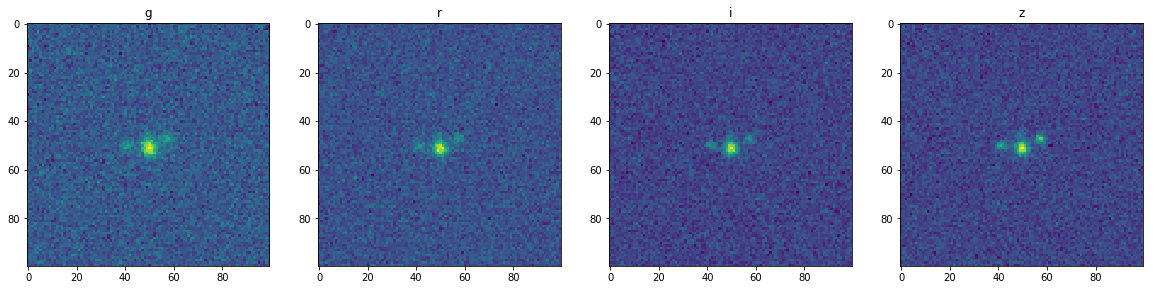

x_image 4


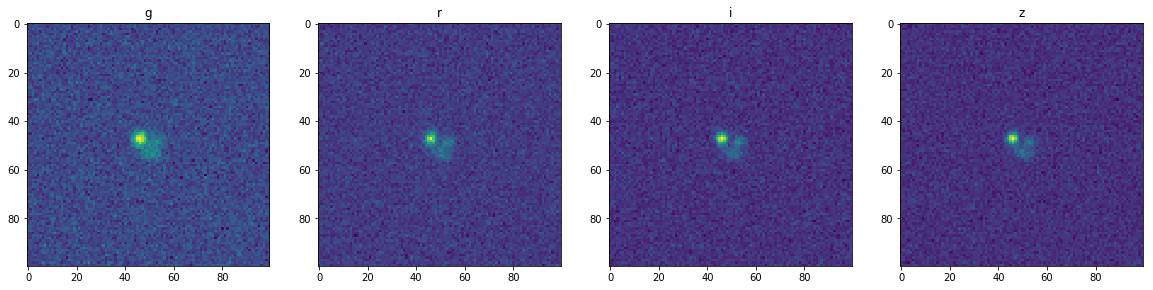

x_image 2


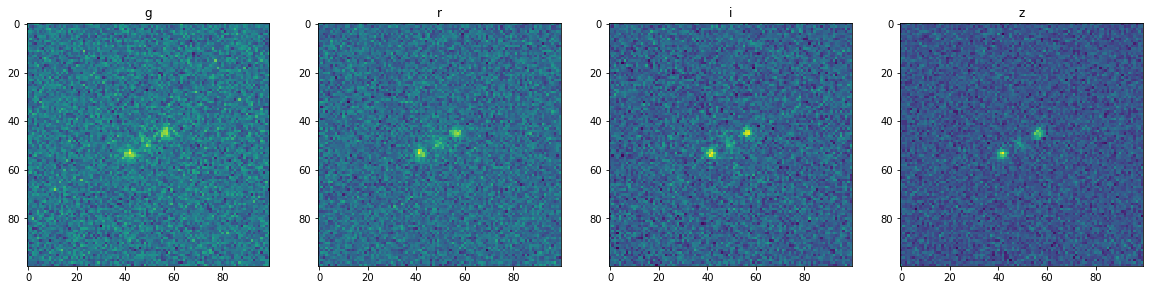

x_image 4


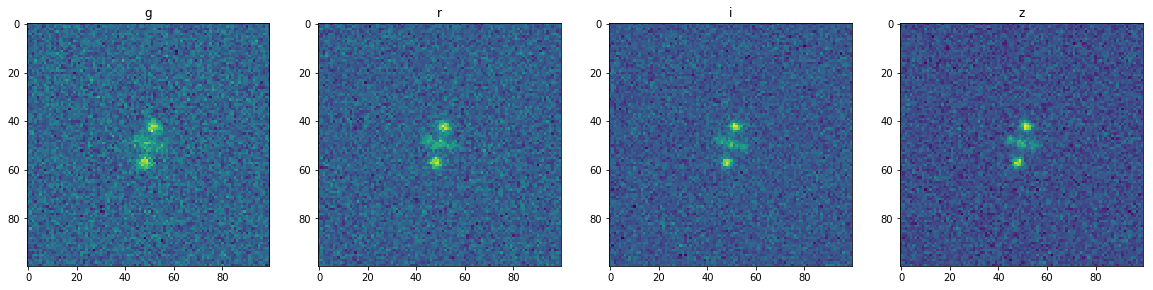

x_image 4


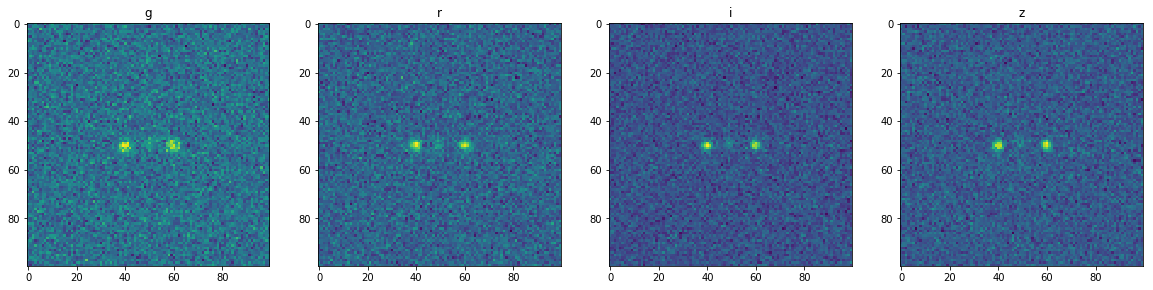

x_image 4


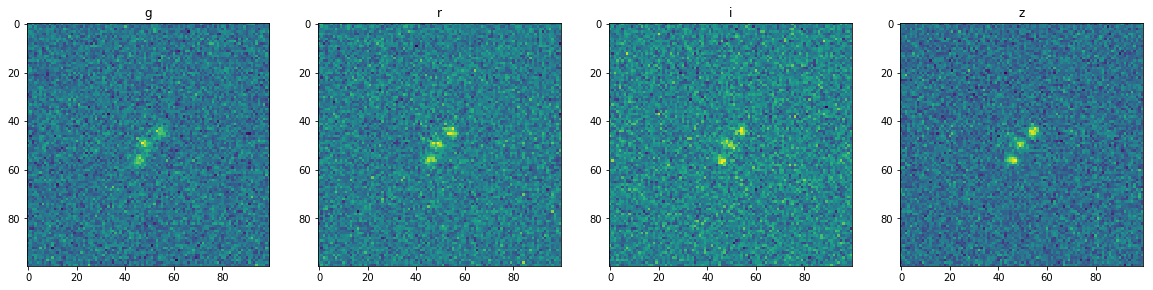

x_image 4


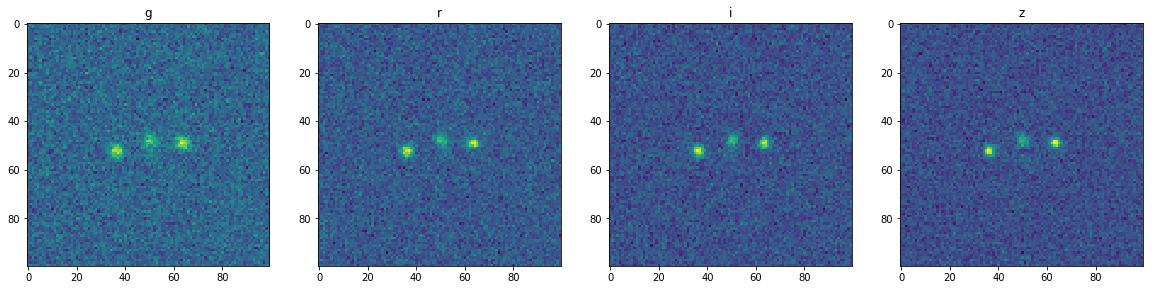

x_image 4


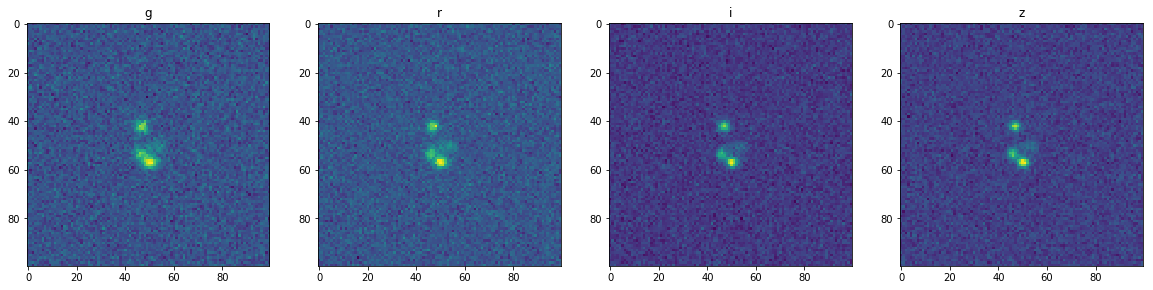

x_image 4


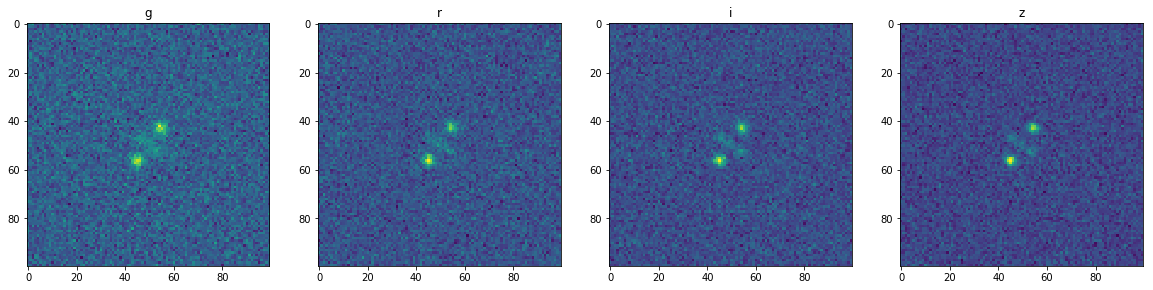

x_image 4


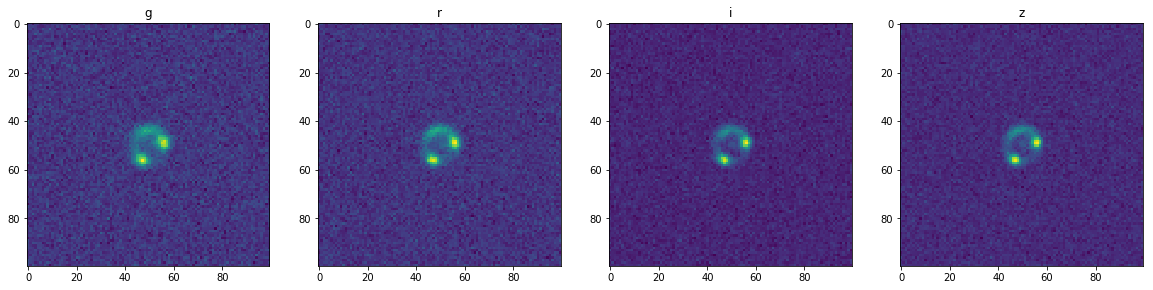

x_image 2


In [22]:
if __name__ == "__main__":
    print("simulation started")
    show_img = True
    IsTrain = False
    num_samples = 10
    root_folder = "./AGN_sims_full_band/"
    if not os.path.exists(root_folder):
        os.mkdir(root_folder)

    if IsTrain:
        np.random.seed(12345)
        file_path = root_folder+"train/"
    else:
        np.random.seed(54321)
        file_path = root_folder+"test/"

    if not os.path.exists(file_path):
        os.mkdir(file_path)
    
    sigma_bkg = 8.0  #  background noise per pixel (Gaussian)
    exp_time = 90.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
    numPix = 100  #  cutout pixel size
    deltaPix = 0.263  #  pixel size in arcsec (area per pixel = deltaPix**2)
    #fwhm = 1.0  # full width half max of PSF (only valid when psf_type='gaussian')
    psf_type = 'GAUSSIAN'  # 'gaussian', 'pixel', 'NONE'
    kernel_size = 91

    bands = ['g', 'r', 'i', 'z']
    
    
    
    
    for i in range(num_samples):
        full_band_images = np.zeros((numPix, numPix, 4))
        mag_agn_seed = np.random.randint(0, 9)
         # generate the coordinate grid and image properties
        
        # lensing quantities

        ### mean of the lens parameters
        gamma_ext_mu, theta_E_mu, gamma_mu, lens_center_mu, lens_e_mu = 0.015, 1.4, 2.0, 0.0, 0.0

        gamma_ext_sigma, theta_E_sigma, gamma_sigma, lens_center_sigma, lens_e_sigma= 0.005, 0.4, 0.05, 0.2, 0.2

        gamma_ext = np.maximum(np.random.normal(gamma_ext_mu, gamma_ext_sigma), 0)
        psi_ext = np.random.uniform(0.0, 2* np.pi)
        theta_E = np.maximum(np.random.normal(loc=theta_E_mu, scale=theta_E_sigma), 0.1)
        gamma = np.maximum(np.random.normal(gamma_mu, gamma_sigma), 1.85)
        lens_center_x = np.random.normal(lens_center_mu, lens_center_sigma)
        lens_center_y = np.random.normal(lens_center_mu, lens_center_sigma)
        lens_e1 = np.minimum(np.random.normal(lens_e_mu, lens_e_sigma), 0.9)
        lens_e2 = np.minimum(np.random.normal(lens_e_mu, lens_e_sigma), 0.9)

        kwargs_shear = {'gamma_ext': gamma_ext, 'psi_ext': psi_ext}  # shear values to the source plane
        kwargs_spemd = {'theta_E': theta_E, 'gamma': gamma, 'center_x': lens_center_x, 'center_y': lens_center_y, 'e1': lens_e1, 'e2': lens_e2}  # parameters of the deflector lens model

        # the lens model is a supperposition of an elliptical lens model with external shear
        lens_model_list = ['SPEP', 'SHEAR_GAMMA_PSI']
        kwargs_lens = [kwargs_spemd, kwargs_shear]
        lens_model_class = LensModel(lens_model_list=lens_model_list)



        # choice of source type
        source_type = 'SERSIC'  # 'SERSIC' or 'SHAPELETS'
        source_position_mu = 0.0
        source_position_sigma = 0.1
        #sigma_source_position = 0.1
        source_x = np.random.normal(source_position_mu, source_position_sigma)
        source_y = np.random.normal(source_position_mu, source_position_sigma)


        # Sersic parameters in the initial simulation
        phi_G, q = 0.5, 0.8
        sersic_source_e1, sersic_source_e2 = param_util.phi_q2_ellipticity(phi_G, q)
        source_R_sersic_mu, source_R_sersic_sigma = 0.2, 0.1
        source_n_sersic_mu, source_n_sersic_sigma = 1.0, 0.1
        source_R_sersic = np.random.normal(source_R_sersic_mu, source_R_sersic_sigma)
        source_n_sersic = np.random.normal(source_n_sersic_mu, source_n_sersic_sigma)



        kwargs_sersic_source = {'amp': 1000, 'R_sersic': source_R_sersic, 'n_sersic': source_n_sersic, 'e1': sersic_source_e1, 'e2': sersic_source_e2, 'center_x': source_x, 'center_y': source_y}
        #kwargs_else = {'sourcePos_x': source_x, 'sourcePos_y': source_y, 'quasar_amp': 400., 'gamma1_foreground': 0.0, 'gamma2_foreground':-0.0}
        source_model_list = ['SERSIC_ELLIPSE']
        kwargs_source = [kwargs_sersic_source]
        source_model_class = LightModel(light_model_list=source_model_list)

        # lens light model
        phi_G, q = 0.9, 0.9
        lens_light_e1, lens_light_e2 = param_util.phi_q2_ellipticity(phi_G, q)
        lens_light_R_sersic_mu, lens_light_R_sersic_sigma = 0.3, 0.1
        lens_light_n_sersic_mu, lens_light_n_sersic_sigma = 1.0, 0.1
        lens_light_R_sersic = np.random.normal(lens_light_R_sersic_mu, lens_light_R_sersic_sigma)
        lens_light_n_sersic = np.random.normal(lens_light_n_sersic_mu, lens_light_n_sersic_sigma)
        kwargs_sersic_lens = {'amp': 1000, 'R_sersic': lens_light_R_sersic, 'n_sersic': lens_light_n_sersic , 'e1': lens_light_e1, 'e2': lens_light_e2, 'center_x': lens_center_x, 'center_y': lens_center_y}
        lens_light_model_list = ['SERSIC_ELLIPSE']
        kwargs_lens_light = [kwargs_sersic_lens]
        lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

        

        
        
        for color_idx, band in enumerate(bands):
        # lensing quantities

            fwhm_list = [1.12, 0.96, 0.88, 0.84] # PSF median from arXiv:1708.01533

            if color_idx ==0:
                mag_agn = mag_g
            elif color_idx ==1:
                mag_agn = mag_r
            elif color_idx ==2:
                mag_agn = mag_i
            elif color_idx ==3:
                mag_agn = mag_z
                
            
                
            

            kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, sigma_bkg)
            data_class = ImageData(**kwargs_data)
            # generate the psf variables
            #kernel_cut = kernel_util.cut_psf(kernel, kernel_size)
            kwargs_psf = {'psf_type': psf_type, 'fwhm':fwhm_list[color_idx], 'pixel_size': deltaPix, 'truncation': 3}
            #kwargs_psf = sim_util.psf_configure_simple(psf_type=psf_type, fwhm=fwhm, kernelsize=kernel_size, deltaPix=deltaPix, kernel=kernel)
            psf_class = PSF(**kwargs_psf)
            
            
            lensEquationSolver = LensEquationSolver(lens_model_class)
            x_image, y_image = lensEquationSolver.findBrightImage(source_x, source_y, kwargs_lens, numImages=4,
                                                                  min_distance=deltaPix, search_window=numPix * deltaPix)
            mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)


            kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                                       'point_amp': np.abs(mag)*mag_agn[mag_agn_seed]}]  # quasar point source position in the source plane and intrinsic brightness
            point_source_list = ['LENSED_POSITION']
            point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])

            kwargs_numerics = {'supersampling_factor': 1}
           
            imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                            lens_light_model_class, point_source_class, kwargs_numerics=kwargs_numerics)

            # generate image
            image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)
            poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
            bkg = image_util.add_background(image_sim, sigma_bkd=sigma_bkg)
            image_sim = image_sim + bkg + poisson
            #image_sim = add_noise(image_sim, kwargs_band =DES_survey_noise)#image_sim# + bkg + poisson

            data_class.update_data(image_sim)
            kwargs_data['image_data'] = image_sim


            kwargs_model = {'lens_model_list': lens_model_list,
                             'lens_light_model_list': lens_light_model_list,
                             'source_light_model_list': source_model_list,
                            'point_source_model_list': point_source_list
                             }
            full_band_images[:, :, color_idx] += image_sim



        ##### saving files
        #np.save(file_path + "lens" + "_" + "%07d" % (i+1) + ".npy", image_sim)
        np.save(file_path + "full_band_lens" + "_" + "%07d" % (i+1) + ".npy", full_band_images)
        ##### saveing parameters
        lens_dict = kwargs_lens[0]
        shear_dict = kwargs_shear
        df_lens  = pd.DataFrame([lens_dict], columns=lens_dict.keys())
        df_lens['gamma_ext'] = gamma_ext
        df_lens['psi_ext'] = psi_ext
        #df_shear = pd.DataFrame([shear_dict], columns=shear_dict.keys())
        df_lens['name'] = "lens" + "_" + "%07d" % (i+1)
        df_lens['source_R_sersic'] = source_R_sersic
        df_lens['source_n_sersic'] = source_n_sersic
        df_lens['sersic_source_e1'] = sersic_source_e1
        df_lens['sersic_source_e2'] = sersic_source_e2
        df_lens['source_x'] = source_x
        df_lens['source_y'] = source_y
        df_lens['lens_light_e1'] = lens_light_e1
        df_lens['lens_light_e2'] = lens_light_e2
        df_lens['lens_light_R_sersic'] = lens_light_R_sersic
        df_lens['lens_light_n_sersic'] = lens_light_n_sersic
        df_lens['ps_counts'] = x_image.size

        # lens_light_R_sersic = np.random.normal(lens_light_R_sersic_mu, lens_light_R_sersic_sigma)
        # lens_light_n_sersic


        if i > 0:
            df_lens_podcast = pd.concat([df_lens_podcast, df_lens], axis =0).reset_index(drop=True)
        else:
            df_lens_podcast = df_lens

        if show_img == True:
            plt.figure(figsize=(20,10))
            plt.subplot(1, 4, 1)
            plt.imshow(full_band_images[:, :, 0])
            plt.title("g")
            plt.subplot(1, 4, 2)
            plt.imshow(full_band_images[:, :, 1])
            plt.title("r")
            plt.subplot(1, 4, 3)
            plt.imshow(full_band_images[:, :, 2])
            plt.title("i")
            plt.subplot(1, 4, 4)
            plt.imshow(full_band_images[:, :, 3])
            plt.title("z")
            plt.show()
#             cmap_string = 'gray'
#             cmap = plt.get_cmap(cmap_string)
#             cmap.set_bad(color='k', alpha=1.)
#             cmap.set_under('k')

#             v_min = -4
#             v_max = 2

#             f, axes = plt.subplots(1, 1, figsize=(3, 3), sharex=False, sharey=False)
#             ax = axes
#             im = ax.matshow(np.log10(image_sim), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
#             ax.get_xaxis().set_visible(False)
#             ax.get_yaxis().set_visible(False)
#             ax.autoscale(False)
#             plt.show()
            #print(df_lens)
            print("x_image", x_image.size)
    df_lens_podcast = df_lens_podcast[['name', 'theta_E', 'gamma', 'center_x', 'center_y', 'e1', 'e2', 'gamma_ext', 'psi_ext', 'source_x', 'source_y', 'source_n_sersic', 'source_R_sersic', 'sersic_source_e1', 'sersic_source_e2', 'lens_light_e1', 'lens_light_e2', 'lens_light_n_sersic', 'lens_light_R_sersic', 'ps_counts']]
    df_lens_podcast.to_csv(file_path + "lens_info.csv")
    

In [23]:
from lenstronomy.SimulationAPI.sim_api import SimAPI
data = pd.read_csv('merged_agn_lc.csv')
data




#SimAPI.magnitude2amplitude(kwargs_source_mag=kwargs_sersic_lens_mag)

,Unnamed: 0,NITE,mag_g,mag_r,mag_i,mag_z,psf_g,psf_r,psf_i,psf_z,skymag_g,skymag_r,skymag_i,skymag_z,zpt_g,zpt_r,zpt_i,zpt_z,z_source
0,0,0,21.011849,21.074964,21.145781,20.993683,1.148167,0.975156,0.912242,1.022341,30.105792,29.000568,27.737380,29.474200,33.0,33.0,33.0,33.0,1.29303
1,1,3,20.884923,21.161249,21.176319,20.707863,1.006612,1.038069,1.195352,1.006612,27.579484,29.000568,28.368939,27.579484,33.0,33.0,33.0,33.0,1.29303
2,2,6,21.106750,21.210126,20.979312,21.013516,1.038069,1.100982,0.975156,1.242537,27.895286,28.842662,27.421586,30.421610,33.0,33.0,33.0,33.0,1.29303
3,3,9,20.975590,21.137899,21.081708,21.107799,0.927971,1.242537,1.179624,1.069525,30.105792,28.211055,29.000568,27.579484,33.0,33.0,33.0,33.0,1.29303
4,4,12,20.811789,20.886642,21.056919,20.659824,1.053797,0.927971,1.195352,1.148167,30.421610,30.105792,27.579484,27.421586,33.0,33.0,33.0,33.0,1.29303
5,5,15,20.609174,20.841524,20.678174,20.743618,1.022341,1.195352,1.053797,1.069525,30.105792,30.421610,28.211055,28.684764,33.0,33.0,33.0,33.0,1.29303
6,6,18,20.597712,20.647749,20.618032,20.662012,1.132439,1.038069,1.179624,1.132439,30.263752,30.105792,27.895286,29.947991,33.0,33.0,33.0,33.0,1.29303
7,7,21,20.661055,20.777107,20.629937,20.621452,1.132439,1.053797,1.163895,1.195352,29.947991,28.842662,29.316334,28.684764,33.0,33.0,33.0,33.0,1.29303
8,8,24,20.694283,20.778425,20.665819,20.632052,1.179624,1.006612,1.195352,0.959427,29.316334,29.632168,28.211055,29.158411,33.0,33.0,33.0,33.0,1.29303
9,9,27,20.883924,20.664488,20.892433,20.770627,1.242537,0.912242,1.148167,1.038069,28.684764,27.895286,27.579484,28.684764,33.0,33.0,33.0,33.0,1.29303


In [24]:
print(df_lens_podcast.head())

           name   theta_E     gamma  center_x  center_y        e1        e2  \
0  lens_0000001  1.416583  1.972893  0.091932  0.379580 -0.338087  0.113199   
1  lens_0000002  1.058001  2.018394  0.669961 -0.183498  0.005028 -0.162384   
2  lens_0000003  1.602309  2.104810 -0.055849  0.008449 -0.249313  0.441718   
3  lens_0000004  1.677268  2.110503  0.000066 -0.071861  0.232543  0.106989   
4  lens_0000005  1.602291  2.080710 -0.053692 -0.158135 -0.599713  0.023055   

   gamma_ext   psi_ext  source_x  source_y  source_n_sersic  source_R_sersic  \
0   0.008248  5.081649 -0.048435 -0.096600         0.978284         0.060857   
1   0.016510  5.114794  0.049045 -0.089144         1.085238         0.321155   
2   0.012402  0.812863 -0.102855 -0.124605         0.918713         0.164851   
3   0.014349  5.454403  0.042336 -0.009086         0.953824         0.225366   
4   0.011831  0.361014  0.097035  0.083072         1.024159         0.200621   

   sersic_source_e1  sersic_source_e2  lens_